# TP5_ECN7055: Interpolation linéaire et value function iteration

In [38]:
#!conda install -y quantecon
#!pip install interpolation

In [40]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (11, 5)  #set default figure size
import numpy as np
import quantecon as qe
from interpolation import interp
from numpy.random import randn
from numba import njit, prange, float64, int32
#from numba.experimental import jitclass

L'on veut approximer par interpolation linéaire, une fonction connue: $y=2cos(6x)+sin(14x)+2.5$

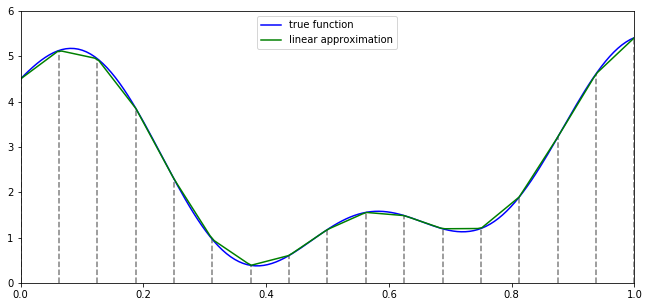

In [41]:
def f(x):
    y1 = 2 * np.cos(6 * x) + np.sin(14 * x)
    return y1 + 2.5

c_grid = np.linspace(0, 1, 17) #pour les lignes verticales sur le graphique 
f_grid = np.linspace(0, 1, 150)

def Af(x):
    return interp(c_grid, f(c_grid), x)

fig, ax = plt.subplots()

ax.plot(f_grid, f(f_grid), 'b-', label='true function')
ax.plot(f_grid, Af(f_grid), 'g-', label='linear approximation')        
ax.vlines(c_grid, c_grid * 0, f(c_grid), linestyle='dashed', alpha=0.5)

ax.legend(loc="upper center")

ax.set(xlim=(0, 1), ylim=(0, 6))
plt.show()

L'objectif de interp(c_grid, f(c_grid), x) est de lier les points c_grid et f(c_grid) par une fonction en générant leur image pour chaque point x par interpolation linéaire. 
Ainsi af(x) génère des images pour tous les points x dans l'ensemble de définition. 

In [43]:
rd_grid=np.linspace(0,200, 10) # si vous depasser les bornes, il va juste s'arreter à la limite pas après
a=Af(rd_grid)
a

array([4.5       , 5.41094793, 5.41094793, 5.41094793, 5.41094793,
       5.41094793, 5.41094793, 5.41094793, 5.41094793, 5.41094793])

# 35. Cake Eating II: Numerical Methods
https://python.quantecon.org/cake_eating_numerical.html#id3


In [44]:
from scipy.optimize import minimize_scalar, bisect

In [45]:
#analitical solution (see cake eating I)
def c_star(x, β, γ):

    return (1 - β ** (1/γ)) * x


def v_star(x, β, γ):

    return (1 - β**(1 / γ))**(-γ) * (x**(1-γ) / (1-γ))

In [21]:
def maximize(g, a, b, args):
    """
    Maximize the function g over the interval [a, b].

    We use the fact that the maximizer of g on any interval is
    also the minimizer of -g.  The tuple args collects any extra
    arguments to g.

    Returns the maximal value and the maximizer.
    """

    objective = lambda x: -g(x, *args)
    result = minimize_scalar(objective, bounds=(a, b), method='bounded')
    maximizer, maximum = result.x, -result.fun
    return maximizer, maximum

In [22]:
help(minimize_scalar)

Help on function minimize_scalar in module scipy.optimize._minimize:

minimize_scalar(fun, bracket=None, bounds=None, args=(), method='brent', tol=None, options=None)
    Minimization of scalar function of one variable.
    
    Parameters
    ----------
    fun : callable
        Objective function.
        Scalar function, must return a scalar.
    bracket : sequence, optional
        For methods 'brent' and 'golden', `bracket` defines the bracketing
        interval and can either have three items ``(a, b, c)`` so that
        ``a < b < c`` and ``fun(b) < fun(a), fun(c)`` or two items ``a`` and
        ``c`` which are assumed to be a starting interval for a downhill
        bracket search (see `bracket`); it doesn't always mean that the
        obtained solution will satisfy ``a <= x <= c``.
    bounds : sequence, optional
        For method 'bounded', `bounds` is mandatory and must have two items
        corresponding to the optimization bounds.
    args : tuple, optional
        E

In [47]:
#a class 
class CakeEating:

    def __init__(self,
                 β=0.96,           # discount factor
                 γ=1.5,            # degree of relative risk aversion
                 x_grid_min=1e-3,  # exclude zero for numerical stability
                 x_grid_max=2.5,   # size of cake
                 x_grid_size=120):

        self.β, self.γ = β, γ

        # Set up grid
        self.x_grid = np.linspace(x_grid_min, x_grid_max, x_grid_size)

    # Utility function
    def u(self, c):

        γ = self.γ

        if γ == 1:
            return np.log(c)
        else:
            return (c ** (1 - γ)) / (1 - γ)

    # first derivative of utility function
    def u_prime(self, c):

        return c ** (-self.γ)

    def state_action_value(self, c, x, v_array):
        """
        Right hand side of the Bellman equation given x and c.
        """

        u, β = self.u, self.β
        v = lambda x: interp(self.x_grid, v_array, x)

        return u(c) + β * v(x - c)

In [48]:
def T(v, ce):
    """
    The Bellman operator.  Updates the guess of the value function.

    * ce is an instance of CakeEating
    * v is an array representing a guess of the value function

    """
    v_new = np.empty_like(v)

    for i, x in enumerate(ce.x_grid):
        # Maximize RHS of Bellman equation at state x
        v_new[i] = maximize(ce.state_action_value, 1e-10, x, (x, v))[1]

    return v_new

In [49]:
ce = CakeEating()

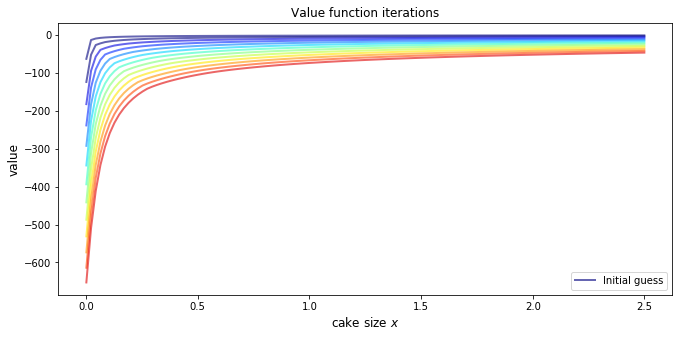

In [50]:
x_grid = ce.x_grid
v = ce.u(x_grid)       # Initial guess
n = 12                 # Number of iterations

fig, ax = plt.subplots()

ax.plot(x_grid, v, color=plt.cm.jet(0),
        lw=2, alpha=0.6, label='Initial guess')

for i in range(n):
    v = T(v, ce)  # Apply the Bellman operator
    ax.plot(x_grid, v, color=plt.cm.jet(i / n), lw=2, alpha=0.6)

ax.legend()
ax.set_ylabel('value', fontsize=12)
ax.set_xlabel('cake size $x$', fontsize=12)
ax.set_title('Value function iterations')

plt.show()

Make a function with a convergence criteria

In [27]:
def compute_value_function(ce,
                           tol=1e-4,
                           max_iter=1000,
                           verbose=True,
                           print_skip=25):

    # Set up loop
    v = np.zeros(len(ce.x_grid)) # Initial guess
    i = 0
    error = tol + 1

    while i < max_iter and error > tol:
        v_new = T(v, ce)

        error = np.max(np.abs(v - v_new))
        i += 1

        if verbose and i % print_skip == 0: #si les conditions du while sont vraies (verbose=True)
            print(f"Error at iteration {i} is {error}.") # et i est tel que 

        v = v_new

    if i == max_iter:
        print("Failed to converge!")

    if verbose and i < max_iter:
        print(f"\nConverged in {i} iterations.")

    return v_new

In [28]:
v = compute_value_function(ce)

Error at iteration 25 is 23.8003755134813.
Error at iteration 50 is 8.577577195046615.
Error at iteration 75 is 3.091330659691039.
Error at iteration 100 is 1.1141054204751981.
Error at iteration 125 is 0.4015199357729671.
Error at iteration 150 is 0.14470646660561215.
Error at iteration 175 is 0.052151735472762084.
Error at iteration 200 is 0.018795314242879613.
Error at iteration 225 is 0.006773769545588948.
Error at iteration 250 is 0.0024412443051460286.
Error at iteration 275 is 0.000879816432870939.
Error at iteration 300 is 0.00031708295398402697.
Error at iteration 325 is 0.00011427565573285392.

Converged in 329 iterations.


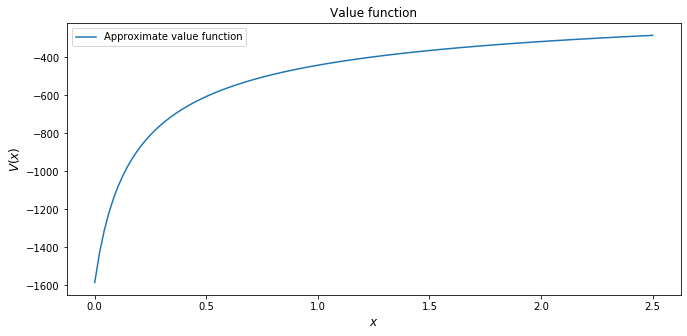

In [29]:
fig, ax = plt.subplots()

ax.plot(x_grid, v, label='Approximate value function')
ax.set_ylabel('$V(x)$', fontsize=12)
ax.set_xlabel('$x$', fontsize=12)
ax.set_title('Value function')
ax.legend()
plt.show()

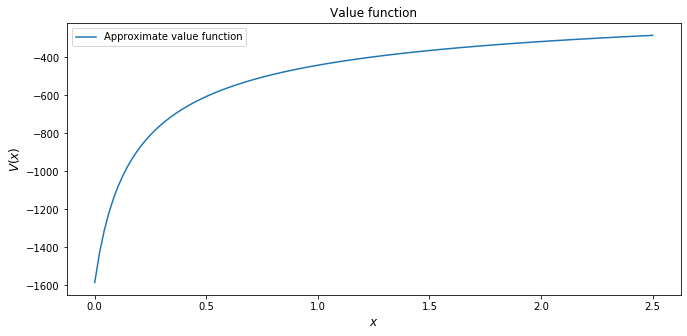

In [30]:
fig, ax = plt.subplots()

ax.plot(x_grid, v, label='Approximate value function')
ax.set_ylabel('$V(x)$', fontsize=12)
ax.set_xlabel('$x$', fontsize=12)
ax.set_title('Value function')
ax.legend()
plt.show()

In [31]:
v_analytical = v_star(ce.x_grid, ce.β, ce.γ)

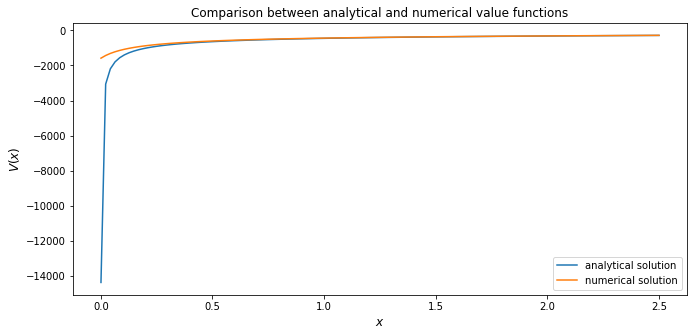

In [32]:
fig, ax = plt.subplots()

ax.plot(x_grid, v_analytical, label='analytical solution')
ax.plot(x_grid, v, label='numerical solution')
ax.set_ylabel('$V(x)$', fontsize=12)
ax.set_xlabel('$x$', fontsize=12)
ax.legend()
ax.set_title('Comparison between analytical and numerical value functions')
plt.show()

# Policy Function (next time)

In [35]:
def σ(ce, v):
    """
    The optimal policy function. Given the value function,
    it finds optimal consumption in each state.

    * ce is an instance of CakeEating
    * v is a value function array

    """
    c = np.empty_like(v)

    for i in range(len(ce.x_grid)):
        x = ce.x_grid[i]
        # Maximize RHS of Bellman equation at state x
        c[i] = maximize(ce.state_action_value, 1e-10, x, (x, v))[0]

    return c

In [36]:
c = σ(ce, v)

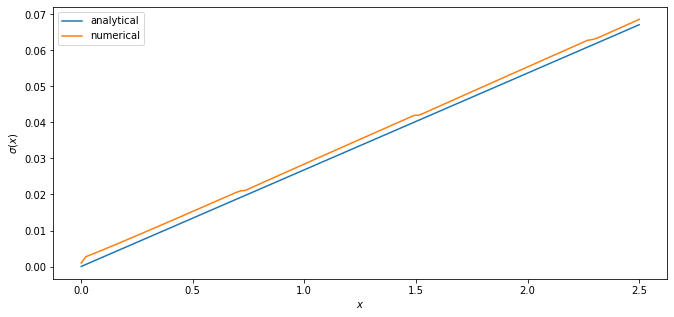

In [37]:
c_analytical = c_star(ce.x_grid, ce.β, ce.γ)

fig, ax = plt.subplots()

ax.plot(ce.x_grid, c_analytical, label='analytical')
ax.plot(ce.x_grid, c, label='numerical')
ax.set_ylabel(r'$\sigma(x)$')
ax.set_xlabel('$x$')
ax.legend()

plt.show()

The fit is reasonable but not perfect.

We can improve it by increasing the grid size or reducing the error tolerance in the value function iteration routine.

But this increases the computation time.